Importa as bibliotecas necessárias para o pré-processamento do Dataset

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
%matplotlib inline

Carrega o Dataset bruto

In [12]:
df_prop = pd.read_excel('Dataset.xlsx')

Visualiza informações básicas do conteúdo do Dataset

In [13]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46319 entries, 0 to 46318
Data columns (total 3 columns):
ANO_PROPOSICAO                  46319 non-null int64
AREAS_TEMATICAS_APRESENTACAO    46319 non-null object
TEXTO                           46319 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [14]:
df_prop.head(7)

,ANO_PROPOSICAO,AREAS_TEMATICAS_APRESENTACAO,TEXTO
0,2003,"INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR (UT...",Dispõe sobre o prazo para devolução de encomen...
1,2003,ARTE E CULTURA,Confere ao município de Passo Fundo o título d...
2,2003,ARTE E CULTURA,Inscreve o nome de Heitor Villa-Lobos no Livro...
3,2003,TRIBUTACAO,Dispõe sobre a isenção do Imposto sobre Produt...
4,2004,SEGURANCA PUBLICA,"""Autoriza o uso, pelas Polícias Civil e Milita..."
5,2003,"ECONOMIA, ADMINISTRACAO FINANCEIRA E ORCAMENTA...",Acrescenta dispositivo à Lei Complementar nº 1...
6,2003,EDUCACAO,Dá nova redação ao art. 208 da Constituição Fe...


Simplifica nome de colunas do Dataset

In [15]:
df_prop.rename(columns={'ANO_PROPOSICAO': 'ANO', 'AREAS_TEMATICAS_APRESENTACAO': 'TEMAS'}, inplace=True)
df_prop.head(3)

,ANO,TEMAS,TEXTO
0,2003,"INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR (UT...",Dispõe sobre o prazo para devolução de encomen...
1,2003,ARTE E CULTURA,Confere ao município de Passo Fundo o título d...
2,2003,ARTE E CULTURA,Inscreve o nome de Heitor Villa-Lobos no Livro...


Remove colunas que não serão utilizadas

In [16]:
df_prop.drop('ANO', axis=1, inplace=True)

Identifica a quantidade total de temas presentes no Dataset

In [17]:
df_prop['TEMAS'].nunique()

585

Conta a quantidade de entradas para cada tema, remove temas que aparecem menos que 100 vezes no Dataset e reorganiza o index numérico.

In [18]:
counts = df_prop['TEMAS'].value_counts()
df_prop = df_prop[df_prop['TEMAS'].isin(counts[counts > 100].index)]
df_prop.reset_index(drop = True, inplace = True)
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38971 entries, 0 to 38970
Data columns (total 2 columns):
TEMAS    38971 non-null object
TEXTO    38971 non-null object
dtypes: object(2)
memory usage: 609.0+ KB


Verifica a quantidade de temas existentes no Dataset

In [19]:
df_prop['TEMAS'].nunique()

45

Elimina o texto "(UTILIZADO ATE A LEGISLATURA 53)" existente em diversos nomes de temas para melhorar visualização e operação com os temas.

In [20]:
for index, tema in df_prop.iterrows():
    legis_53 = '(UTILIZADO ATE A LEGISLATURA 53)'
    if legis_53 in tema['TEMAS']:
        tema_processado = tema['TEMAS'].replace(legis_53, '')
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_processado

In [21]:
df_prop.head(5)

,TEMAS,TEXTO
0,"INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR",Dispõe sobre o prazo para devolução de encomen...
1,ARTE E CULTURA,Confere ao município de Passo Fundo o título d...
2,ARTE E CULTURA,Inscreve o nome de Heitor Villa-Lobos no Livro...
3,TRIBUTACAO,Dispõe sobre a isenção do Imposto sobre Produt...
4,SEGURANCA PUBLICA,"""Autoriza o uso, pelas Polícias Civil e Milita..."


In [22]:
df_prop.to_excel('Dataset_processed.xlsx',sheet_name='Dataset')

Revalida quantos temas ainda existem no Dataset após a limpeza

In [23]:
df_prop['TEMAS'].nunique()

45

Mostra a quantidade de entradas para cada um dos temas restantes após a limpeza

In [24]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                                               8466
TRABALHO E EMPREGO                                                         2455
ADMINISTRACAO PUBLICA                                                      2356
EDUCACAO                                                                   2073
TRIBUTACAO                                                                 2056
DIREITO PENAL E PROCESSUAL PENAL                                           1788
SAUDE                                                                      1539
DIREITOS HUMANOS, MINORIAS E CIDADANIA                                     1439
VIACAO E TRANSPORTES                                                       1359
HOMENAGENS E DATAS COMEMORATIVAS                                           1219
DIREITO CIVIL E PROCESSUAL CIVIL                                           1218
DESENVOLVIMENTO URBANO E TRANSITO                                          1053
ORGANIZACAO POLITICO ADMINISTRATIVA DO E

Une todas as subcategorias do tema DIREITOS HUMANOS, MINORIAS E CIDADANIA em um único grande grupo

In [25]:
for index, tema in df_prop.iterrows():
    tema_chave = 'DIREITOS HUMANOS, MINORIAS E CIDADANIA'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_chave

Realiza recontagem de temas após a união dos temas de DIREITOS HUMANOS, MINORIAS E CIDADANIA

In [26]:
df_prop['TEMAS'].nunique()

39

In [27]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                              8466
TRABALHO E EMPREGO                                        2455
DIREITOS HUMANOS, MINORIAS E CIDADANIA                    2439
ADMINISTRACAO PUBLICA                                     2356
EDUCACAO                                                  2073
TRIBUTACAO                                                2056
DIREITO PENAL E PROCESSUAL PENAL                          1788
SAUDE                                                     1539
VIACAO E TRANSPORTES                                      1359
HOMENAGENS E DATAS COMEMORATIVAS                          1219
DIREITO CIVIL E PROCESSUAL CIVIL                          1218
DESENVOLVIMENTO URBANO E TRANSITO                         1053
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO             1023
PREVIDENCIA E ASSISTENCIA SOCIAL                          1005
INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR                 961
SEGURANCA PUBLICA                                      

In [28]:
for index, tema in df_prop.iterrows():
    tema_chave = 'PREVIDENCIA E ASSISTENCIA SOCIAL'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_chave

In [29]:
df_prop['TEMAS'].nunique()

38

In [30]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                              8466
TRABALHO E EMPREGO                                        2455
DIREITOS HUMANOS, MINORIAS E CIDADANIA                    2439
ADMINISTRACAO PUBLICA                                     2356
EDUCACAO                                                  2073
TRIBUTACAO                                                2056
DIREITO PENAL E PROCESSUAL PENAL                          1788
SAUDE                                                     1539
VIACAO E TRANSPORTES                                      1359
HOMENAGENS E DATAS COMEMORATIVAS                          1219
DIREITO CIVIL E PROCESSUAL CIVIL                          1218
PREVIDENCIA E ASSISTENCIA SOCIAL                          1125
DESENVOLVIMENTO URBANO E TRANSITO                         1053
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO             1023
INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR                 961
SEGURANCA PUBLICA                                      

In [31]:
for index, tema in df_prop.iterrows():
    tema_chave = 'INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_chave

In [32]:
df_prop['TEMAS'].nunique()

36

In [33]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                          8466
TRABALHO E EMPREGO                                    2455
DIREITOS HUMANOS, MINORIAS E CIDADANIA                2439
ADMINISTRACAO PUBLICA                                 2356
EDUCACAO                                              2073
TRIBUTACAO                                            2056
DIREITO PENAL E PROCESSUAL PENAL                      1788
SAUDE                                                 1539
VIACAO E TRANSPORTES                                  1359
HOMENAGENS E DATAS COMEMORATIVAS                      1219
DIREITO CIVIL E PROCESSUAL CIVIL                      1218
INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR            1183
PREVIDENCIA E ASSISTENCIA SOCIAL                      1125
DESENVOLVIMENTO URBANO E TRANSITO                     1053
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         1023
SEGURANCA PUBLICA                                      960
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL            7

In [34]:
for index, tema in df_prop.iterrows():
    tema_chave = 'ORGANIZACAO ADMINISTRATIVA DO ESTADO'
    tema_alvo = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_alvo

In [35]:
df_prop['TEMAS'].nunique()

36

In [36]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                          8466
TRABALHO E EMPREGO                                    2455
DIREITOS HUMANOS, MINORIAS E CIDADANIA                2439
ADMINISTRACAO PUBLICA                                 2356
EDUCACAO                                              2073
TRIBUTACAO                                            2056
DIREITO PENAL E PROCESSUAL PENAL                      1788
SAUDE                                                 1539
VIACAO E TRANSPORTES                                  1359
HOMENAGENS E DATAS COMEMORATIVAS                      1219
DIREITO CIVIL E PROCESSUAL CIVIL                      1218
INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR            1183
PREVIDENCIA E ASSISTENCIA SOCIAL                      1125
DESENVOLVIMENTO URBANO E TRANSITO                     1053
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         1023
SEGURANCA PUBLICA                                      960
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL            7

In [37]:
df_prop['TEMAS'].unique()

array(['INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR', 'ARTE E CULTURA',
       'TRIBUTACAO', 'SEGURANCA PUBLICA', 'EDUCACAO',
       'PROCESSO LEGISLATIVO', 'DIREITO CIVIL E PROCESSUAL CIVIL',
       'DIREITOS HUMANOS, MINORIAS E CIDADANIA',
       'MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL',
       'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO ',
       'DIREITO PENAL E PROCESSUAL PENAL',
       'PREVIDENCIA E ASSISTENCIA SOCIAL', 'ADMINISTRACAO PUBLICA',
       'VIACAO E TRANSPORTES', 'DESPORTO E LAZER', 'TRABALHO E EMPREGO',
       'ECONOMIA, ADMINISTRACAO FINANCEIRA E ORCAMENTARIA ', 'SAUDE',
       'DESENVOLVIMENTO REGIONAL', 'COMUNICACOES', 'POLITICA FUNDIARIA',
       'RECURSOS HIDRICOS, MINERAIS E POLITICA ENERGETICA',
       'SAUDE,TRABALHO E EMPREGO', 'DEFESA E SEGURANCA NACIONAL',
       'DESENVOLVIMENTO URBANO E TRANSITO',
       'ORGANIZACAO POLITICA, PARTIDARIA E ELEITORAL',
       'RELACOES INTERNACIONAIS', 'HOMENAGENS E DATAS COMEMORATIVAS',
       'ADMINISTRACAO PUBL

In [38]:
for index, tema in df_prop.iterrows():
    tema_chave = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO '
    tema_alvo = 'ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_alvo

In [39]:
df_prop['TEMAS'].nunique()

35

In [40]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                          8466
TRABALHO E EMPREGO                                    2455
DIREITOS HUMANOS, MINORIAS E CIDADANIA                2439
ADMINISTRACAO PUBLICA                                 2356
EDUCACAO                                              2073
TRIBUTACAO                                            2056
DIREITO PENAL E PROCESSUAL PENAL                      1788
SAUDE                                                 1539
VIACAO E TRANSPORTES                                  1359
HOMENAGENS E DATAS COMEMORATIVAS                      1219
DIREITO CIVIL E PROCESSUAL CIVIL                      1218
INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR            1183
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         1168
PREVIDENCIA E ASSISTENCIA SOCIAL                      1125
DESENVOLVIMENTO URBANO E TRANSITO                     1053
SEGURANCA PUBLICA                                      960
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL            7

In [41]:
for index, tema in df_prop.iterrows():
    tema_chave = 'ADMINISTRACAO PUBLICA'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_chave

In [42]:
df_prop['TEMAS'].nunique()

34

In [43]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                          8466
ADMINISTRACAO PUBLICA                                 2459
TRABALHO E EMPREGO                                    2455
DIREITOS HUMANOS, MINORIAS E CIDADANIA                2439
EDUCACAO                                              2073
TRIBUTACAO                                            2056
DIREITO PENAL E PROCESSUAL PENAL                      1788
SAUDE                                                 1539
VIACAO E TRANSPORTES                                  1359
HOMENAGENS E DATAS COMEMORATIVAS                      1219
DIREITO CIVIL E PROCESSUAL CIVIL                      1218
INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR            1183
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         1168
PREVIDENCIA E ASSISTENCIA SOCIAL                      1125
DESENVOLVIMENTO URBANO E TRANSITO                     1053
SEGURANCA PUBLICA                                      960
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL            7

In [44]:
for index, tema in df_prop.iterrows():
    tema_chave = 'EDUCACAO'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_chave

In [45]:
for index, tema in df_prop.iterrows():
    tema_chave = 'TRABALHO E EMPREGO'
    if tema_chave in tema['TEMAS']:
        df_prop.at[df_prop.index[index], 'TEMAS'] = tema_chave

In [46]:
df_prop['TEMAS'].nunique()

32

In [47]:
df_prop['TEMAS'].value_counts()

COMUNICACOES                                          8466
TRABALHO E EMPREGO                                    2575
ADMINISTRACAO PUBLICA                                 2459
DIREITOS HUMANOS, MINORIAS E CIDADANIA                2439
EDUCACAO                                              2178
TRIBUTACAO                                            2056
DIREITO PENAL E PROCESSUAL PENAL                      1788
SAUDE                                                 1539
VIACAO E TRANSPORTES                                  1359
HOMENAGENS E DATAS COMEMORATIVAS                      1219
DIREITO CIVIL E PROCESSUAL CIVIL                      1218
INDUSTRIA, COMERCIO E DEFESA DO CONSUMIDOR            1183
ORGANIZACAO POLITICO ADMINISTRATIVA DO ESTADO         1168
PREVIDENCIA E ASSISTENCIA SOCIAL                      1125
DESENVOLVIMENTO URBANO E TRANSITO                     1053
SEGURANCA PUBLICA                                      960
MEIO AMBIENTE E DESENVOLVIMENTO SUSTENTAVEL            7

In [48]:
df_prop.sort_values(by='TEMAS', ascending=True, inplace=True)

In [49]:
df_prop.describe()

,TEMAS,TEXTO
count,38971,38971
unique,32,37378
top,COMUNICACOES,"Altera a Lei Complementar nº 123, de 14 de dez..."
freq,8466,28


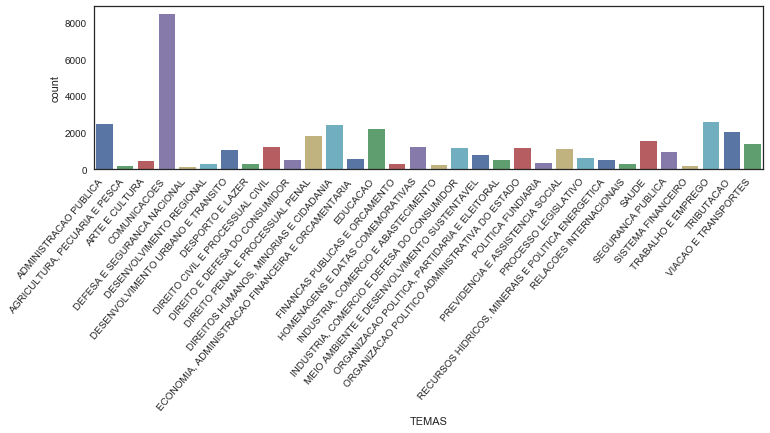

In [50]:
sns.set_context("notebook")
sns.set_style('white')
plt.figure(figsize=(12,3))
countplot = sns.countplot(x=df_prop['TEMAS'], data=df_prop, palette='deep')
plt.setp(countplot.get_xticklabels(), rotation=50, ha="right")
countplot

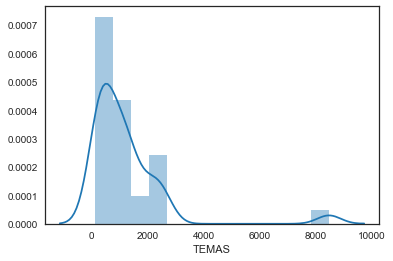

In [51]:
sns.distplot(df_prop['TEMAS'].value_counts())

In [52]:
sns.boxplot(x="ANO", y=df_prop["TEMAS"], data=df_prop,palette='rainbow')

ValueError: Could not interpret input 'ANO'